### BTC Price Prediction using LSTM

For our data science project within the Seminar topics in fintech, we will use a Long Short-Term Memory (LSTM) model to predict future Bitcoin prices. Specifically, we aim to forecast the prices or the trend for the next 50 days.

In [1]:
# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation

import os  # For interacting with the operating system

# Walk through the directory structure in the specified path
for dirname, _, filenames in os.walk('/kaggle/input'):
    # Loop through the files in each directory
    for filename in filenames:
        # Construct the full path and print it
        full_path = os.path.join(dirname, filename)
        print(full_path)

### Data retrieval

In [2]:
# Define the file path. Adjust the username and path to match your local environment.
file_path = '/Users/moritzrichter/Desktop/7. Data Science Project/Bitcoin Price Prediction using Machine Learning/data/portfolio_data.csv'

# Load the dataset from the specified file path
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to ensure it has loaded correctly
print(df.head())

       Date        AMZN        DPZ         BTC       NFLX
0  5/1/2013  248.229996  51.190983  106.250000  30.415714
1  5/2/2013  252.550003  51.987320   98.099998  30.641428
2  5/3/2013  258.049988  52.446388  112.900002  30.492857
3  5/6/2013  255.720001  53.205257  109.599998  30.098572
4  5/7/2013  257.730011  54.151505  113.199997  29.464285


In [3]:
# Import matplotlib and seaborn for data visualization. Matplotlib is a plotting library, 
# and seaborn is a statistical data visualization library that builds on matplotlib.
import matplotlib.pyplot as plt
import seaborn as sns

# This line ensures that plots are displayed inline within the Jupyter Notebook directly below the code cells that produce them.
%matplotlib inline

# Assuming 'df' is a DataFrame with a column named 'BTC' for Bitcoin prices,
# this line calculates and displays descriptive statistics for the 'BTC' column,
# including count, mean, standard deviation, min, and max values, and the quartiles.
df.BTC.describe()

count     1520.000000
mean      2421.465669
std       3310.894199
min         69.660004
25%        340.904999
50%        625.304993
75%       3874.912415
max      18972.320310
Name: BTC, dtype: float64

In [4]:
BTC = df.BTC

In [5]:
BTC.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1520 entries, 0 to 1519
Series name: BTC
Non-Null Count  Dtype  
--------------  -----  
1520 non-null   float64
dtypes: float64(1)
memory usage: 12.0 KB


As the data only has one column, we cannot use this data as it does not contain closing prices, opening prices and volume. We have to get our data from the Yahoo Finance library.

In [6]:
!pip install yfinance

In [7]:
# Import DataReader from pandas_datareader to fetch financial data from various Internet sources
from pandas_datareader.data import DataReader
# Import yfinance, an alternative library that accesses Yahoo Finance data, and overrides pandas_datareader's default methods
import yfinance as yf
from pandas_datareader import data as pdr

# Apply yfinance's override to pandas_datareader's methods to improve data fetching reliability and speed
yf.pdr_override()

# Import datetime for handling and formatting date objects
from datetime import datetime

# Define the stock symbol for Bitcoin as used in Yahoo Finance's listings
stock_symbol = "BTC-USD"
# Set the start date for historical data retrieval
start_date = "2020-01-01"
# Set the end date for the data retrieval to today's date, formatted as 'YYYY-MM-DD'
end_date = datetime.today().strftime('%Y-%m-%d')

# Fetch historical Bitcoin data from Yahoo Finance using the defined time range
BTC = yf.download(stock_symbol, start=start_date, end=end_date)

# Display the fetched data to check its contents and structure
print(BTC)

[*********************100%%**********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2020-01-01   7194.892090   7254.330566   7174.944336   7200.174316   
2020-01-02   7202.551270   7212.155273   6935.270020   6985.470215   
2020-01-03   6984.428711   7413.715332   6914.996094   7344.884277   
2020-01-04   7345.375488   7427.385742   7309.514160   7410.656738   
2020-01-05   7410.451660   7544.497070   7400.535645   7411.317383   
...                  ...           ...           ...           ...   
2024-04-12  70061.382812  71222.742188  65254.835938  67195.867188   
2024-04-13  67188.375000  67931.429688  60919.105469  63821.472656   
2024-04-14  63836.230469  65824.429688  62205.851562  65738.726562   
2024-04-15  65739.648438  66878.648438  62332.070312  63426.210938   
2024-04-16  63419.296875  64355.667969  61716.402344  63811.863281   

               Adj C

### Exploratory Data Analysis

In [8]:
BTC.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1568.000000,1568.000000,1568.000000,1568.000000,1568.000000,1.568000e+03
mean,30684.531210,31385.511616,29938.230724,30717.962483,30717.962483,3.228442e+10
std,16346.232069,16774.387368,15854.178353,16353.282992,16353.282992,1.863577e+10
min,5002.578125,5331.833984,4106.980957,4970.788086,4970.788086,5.331173e+09
25%,18101.025391,18581.168945,17615.536133,18147.839355,18147.839355,2.016342e+10
50%,28572.361328,29160.362305,28176.120117,28654.055664,28654.055664,2.922617e+10
75%,42571.726562,43348.589844,41709.841797,42584.416016,42584.416016,3.954041e+10
max,73079.375000,73750.070312,71334.093750,73083.500000,73083.500000,3.509679e+11


In [9]:
BTC.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1568 entries, 2020-01-01 to 2024-04-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1568 non-null   float64
 1   High       1568 non-null   float64
 2   Low        1568 non-null   float64
 3   Close      1568 non-null   float64
 4   Adj Close  1568 non-null   float64
 5   Volume     1568 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 85.8 KB


Plotting the closing price of the stock.

/Users/moritzrichter/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/moritzrichter/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


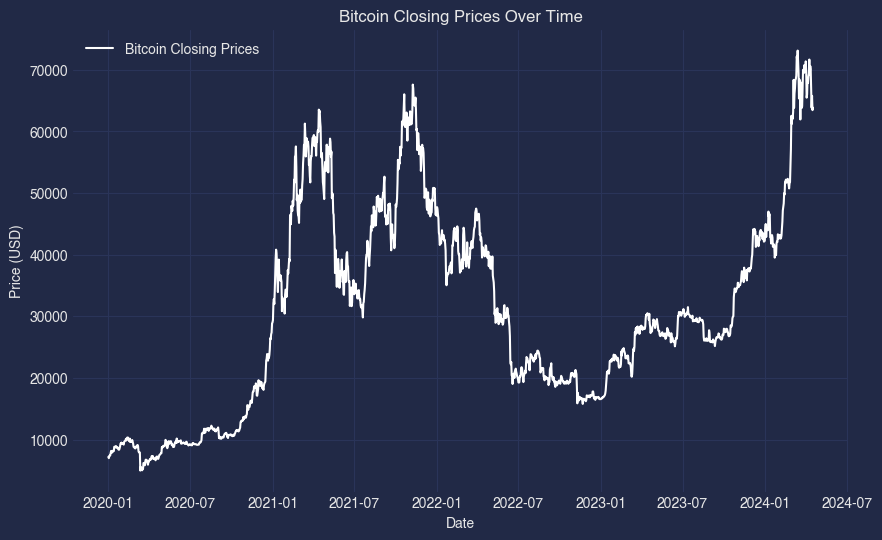

In [10]:
# Set the plot style by importing a custom style from a GitHub repository URL. This style is applied globally to all plots.
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Create a new figure for plotting with specified dimensions (width: 10 inches, height: 6 inches)
plt.figure(figsize=(10, 6))

# Plot the closing prices of Bitcoin. The 'Close' column of the 'BTC' DataFrame is used as data. 
# The line color is set to white, and a label is added for the legend.
sns.lineplot(data=BTC['Close'], color='white', label='Bitcoin Closing Prices')

# Set the title of the plot
plt.title('Bitcoin Closing Prices Over Time')

# Set the label for the x-axis
plt.xlabel('Date')

# Set the label for the y-axis
plt.ylabel('Price (USD)')

# Display the legend in the plot to identify the plotted data
plt.legend()

# Display the plot on the screen
plt.show()

Creating a seperate column for percent change and saving it as 1 if the percent change of the day is positive, 0 otherwise.

In [11]:
# Calculate the daily percentage change in the 'Close' price of Bitcoin and store it in a new column 'Daily_Percentage_Change'.
# The `pct_change()` function calculates the percentage change between the current and prior element.
BTC['Daily_Percentage_Change'] = BTC['Close'].pct_change()

# Create a new column 'Profit_Loss' in the DataFrame. This column will contain a 1 if the daily percentage change is positive 
# (indicating a profit), and a 0 if negative (indicating a loss). The decision is made using a lambda function applied to each value 
# in 'Daily_Percentage_Change'.
BTC['Profit_Loss'] = BTC['Daily_Percentage_Change'].apply(lambda x: 1 if x > 0 else 0)

In [12]:
print(BTC.tail())  # Display the last few rows of the DataFrame

                    Open          High           Low         Close  \
Date                                                                 
2024-04-12  70061.382812  71222.742188  65254.835938  67195.867188   
2024-04-13  67188.375000  67931.429688  60919.105469  63821.472656   
2024-04-14  63836.230469  65824.429688  62205.851562  65738.726562   
2024-04-15  65739.648438  66878.648438  62332.070312  63426.210938   
2024-04-16  63419.296875  64355.667969  61716.402344  63811.863281   

               Adj Close       Volume  Daily_Percentage_Change  Profit_Loss  
Date                                                                         
2024-04-12  67195.867188  44129299406                -0.040889            0  
2024-04-13  63821.472656  52869738185                -0.050217            0  
2024-04-14  65738.726562  49084320047                 0.030041            1  
2024-04-15  63426.210938  43595917654                -0.035177            0  
2024-04-16  63811.863281  42847528078    

We will plot the distribution of days with positive changes versus days with negative changes to evaluate the frequency of upward versus downward movements in the stock's price. This analysis reveals that the stock is more susceptible to negative percentage changes. Consequently, buying at the opening price and selling at the closing price would likely result in a loss at least 60% of the time, if not more frequently.

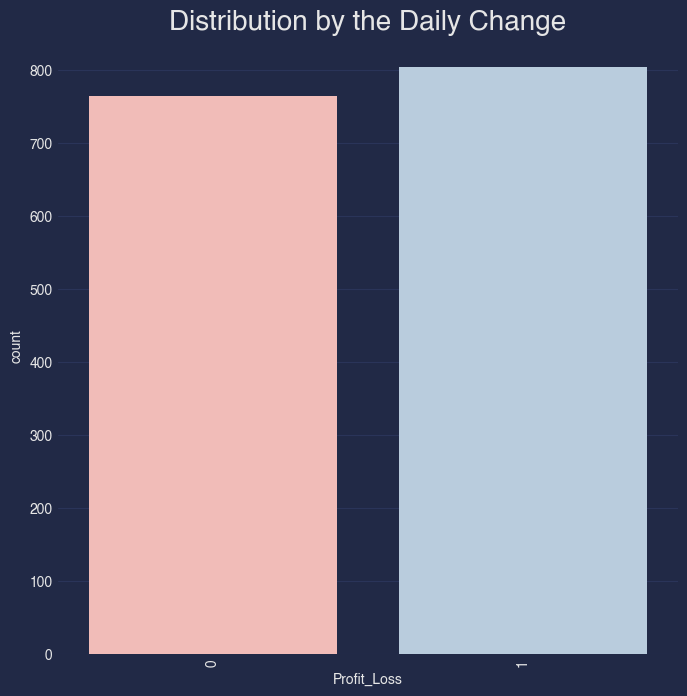

In [13]:
# Set a custom plot style from an external URL. This style applies a dark theme named 'pitayasmoothie-dark' from the specified GitHub repository.
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Create a new figure for plotting with dimensions set to 8x8 inches for better visibility and square aspect ratio.
plt.figure(figsize=(8, 8))

# Create a count plot using seaborn to visualize the distribution of 'Profit_Loss' data in the BTC DataFrame.
# 'Profit_Loss' is used as the categorical x-axis variable, and 'Pastel1' palette is used to color the bars.
sns.countplot(data=BTC, x='Profit_Loss', palette='Pastel1')

# Rotate the x-axis labels by 90 degrees to prevent overlap and enhance readability.
plt.xticks(rotation=90)

# Set the title of the plot with a custom font size of 20 to emphasize the chart's subject.
plt.title('Distribution by the Daily Change', fontsize=20)

# Display the plot on the screen. This command must be called to render the plot when not using interactive environments.
plt.show()

From now on, the visualisations will be more complex, so that we can reduce the data for the visualisation to 250 data sets or about one year.

In [14]:
BTCsample = BTC[-250:]

Some strange spikes in the volume, could be outliers.

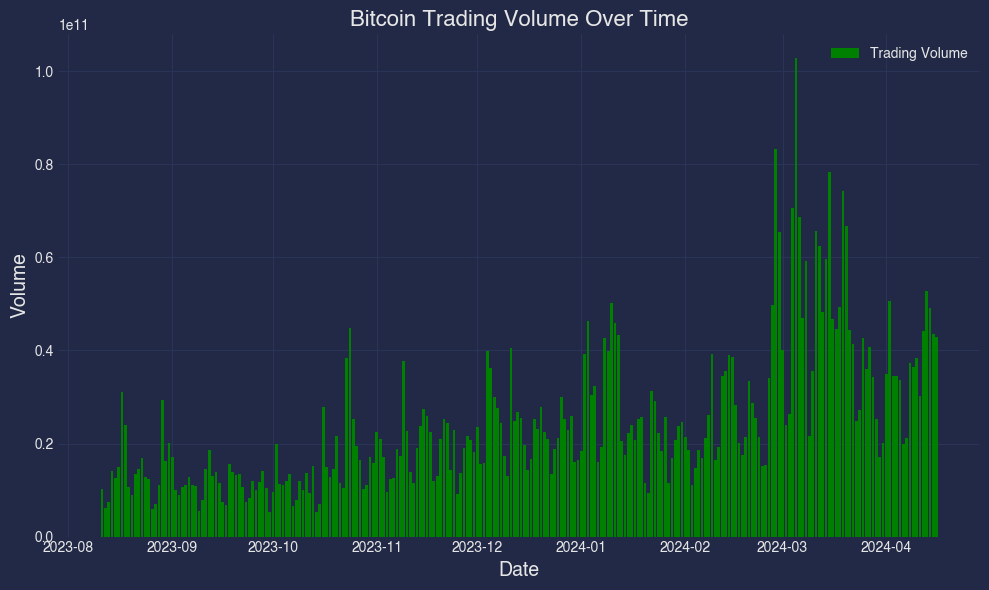

In [15]:
# Create a new figure for plotting with a specified size of 10 inches wide by 6 inches tall to provide ample space for data visualization.
plt.figure(figsize=(10, 6))

# Create a bar chart to visualize the trading volume of Bitcoin over time. The bars are colored green to enhance visual distinction,
# and a label 'Trading Volume' is added for identification in the legend.
plt.bar(BTCsample.index, BTCsample['Volume'], color='green', label='Trading Volume')

# Set the title of the chart with a custom font size of 16 to emphasize the topic and improve readability.
plt.title('Bitcoin Trading Volume Over Time', fontsize=16)

# Label the x-axis as 'Date' with a font size of 14, clarifying the data represented along this axis.
plt.xlabel('Date', fontsize=14)

# Label the y-axis as 'Volume' with a font size of 14, indicating the metric being measured.
plt.ylabel('Volume', fontsize=14)

# Display the legend to identify the plotted data, helping viewers understand the meaning of the green bars.
plt.legend()

# Adjust the layout to make sure all plot components fit neatly within the figure canvas without any overlap.
plt.tight_layout()

# Display the plot on the screen. This function call is necessary to render the plot when using matplotlib in non-interactive environments.
plt.show()

Creating our moving average indicators and using them to create a visually appealing plot with moving averages as well. we will create three moving averages, a 10 day one, a 20 day one and a 50 day one.

/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_237/671115755.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTCsample.loc[:, 'MA10'] = BTCsample['Close'].rolling(window=10).mean().values
/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_237/671115755.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BTCsample.loc[:, 'MA20'] = BTCsample['Close'].rolling(window=20).mean().values
/var/folders/9m/wyctr7ld6vg0x1kjlmlh42hh0000gn/T/ipykernel_237/671115755.py:11: SettingWithCopyWarning: 

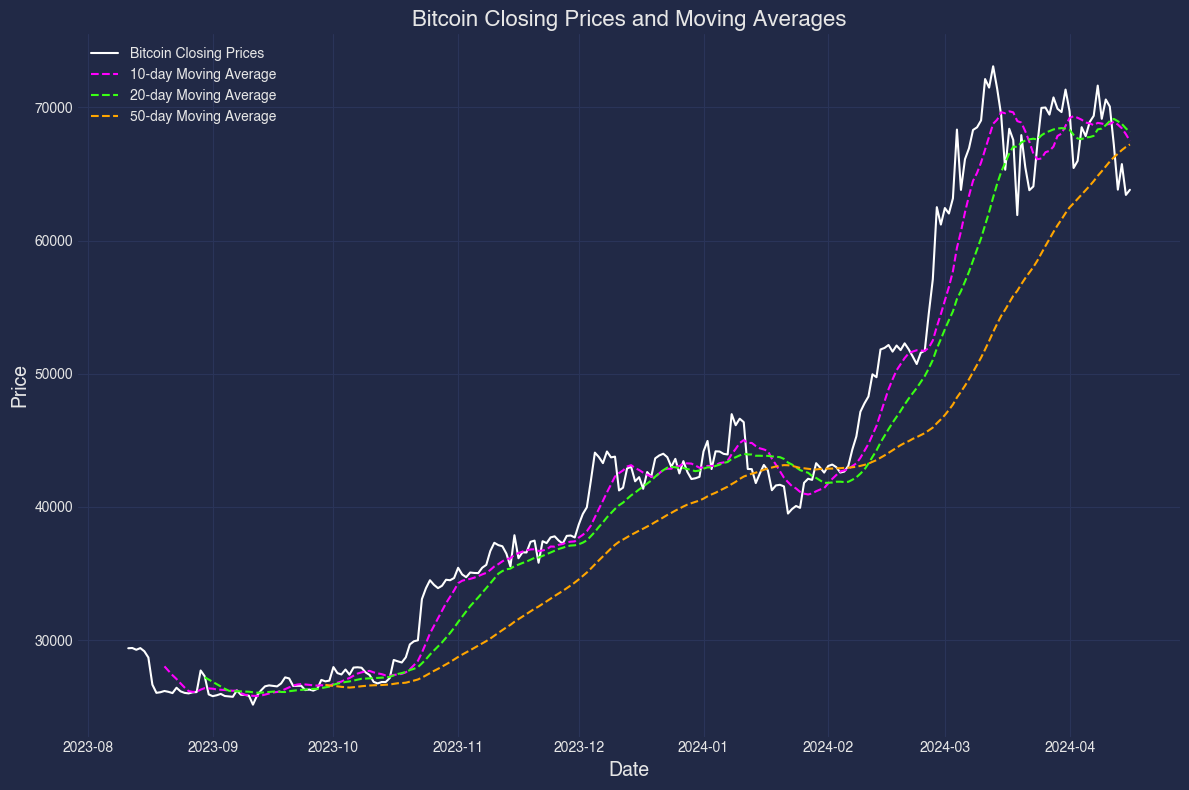

In [16]:
# Create a copy of the BTCsample DataFrame to preserve the original data while making modifications.
BTCsample_copy = BTCsample.copy()

# Calculate and assign the 10-day moving average of the 'Close' prices to a new column 'MA10' in the BTCsample DataFrame.
BTCsample.loc[:, 'MA10'] = BTCsample['Close'].rolling(window=10).mean().values

# Calculate and assign the 20-day moving average of the 'Close' prices to a new column 'MA20'.
BTCsample.loc[:, 'MA20'] = BTCsample['Close'].rolling(window=20).mean().values

# Calculate and assign the 50-day moving average of the 'Close' prices to a new column 'MA50'.
BTCsample.loc[:, 'MA50'] = BTCsample['Close'].rolling(window=50).mean().values

# Create a new figure for plotting with specified dimensions of 12 inches by 8 inches to provide a clear view of the data.
plt.figure(figsize=(12, 8))

# Plot the closing prices of Bitcoin. The data points are represented as a continuous line colored white.
plt.plot(BTCsample.index, BTCsample['Close'], label='Bitcoin Closing Prices', color='white')

# Plot the 10-day moving average with a dashed neon magenta line to distinguish this moving average visually.
plt.plot(BTCsample.index, BTCsample['MA10'], label='10-day Moving Average', linestyle='--', color='#FF00FF')

# Plot the 20-day moving average with a dashed neon green line, providing a visual contrast with other lines.
plt.plot(BTCsample.index, BTCsample['MA20'], label='20-day Moving Average', linestyle='--', color='#39FF14')

# Plot the 50-day moving average with a dashed neon orange line, making it easily distinguishable.
plt.plot(BTCsample.index, BTCsample['MA50'], label='50-day Moving Average', linestyle='--', color='#FFA500')

# Set the title of the chart with a specific font size to emphasize the analysis topic.
plt.title('Bitcoin Closing Prices and Moving Averages', fontsize=16)

# Label the x-axis with 'Date' and set its font size for clarity.
plt.xlabel('Date', fontsize=14)

# Label the y-axis with 'Price' and set its font size, indicating the data metric being measured.
plt.ylabel('Price', fontsize=14)

# Display the legend to identify each line plot, aiding in the visual interpretation of the data trends.
plt.legend()

# Adjust the layout of the plot elements to ensure everything is visible and well-spaced within the plot area.
plt.tight_layout()

# Display the plot on the screen. This call is necessary to render the plot visually in non-interactive Python environments.
plt.show()

In [17]:
# Display the last five rows of the BTC DataFrame to inspect the most recent data entries. 
# The .tail() method is useful for quickly checking the latest values in a dataset, particularly in financial time series like this one.
BTC.tail()

,Open,High,Low,Close,Adj Close,Volume,Daily_Percentage_Change,Profit_Loss
Date,,,,,,,,
2024-04-12,70061.382812,71222.742188,65254.835938,67195.867188,67195.867188,44129299406,-0.040889,0
2024-04-13,67188.375000,67931.429688,60919.105469,63821.472656,63821.472656,52869738185,-0.050217,0
2024-04-14,63836.230469,65824.429688,62205.851562,65738.726562,65738.726562,49084320047,0.030041,1
2024-04-15,65739.648438,66878.648438,62332.070312,63426.210938,63426.210938,43595917654,-0.035177,0
2024-04-16,63419.296875,64355.667969,61716.402344,63811.863281,63811.863281,42847528078,0.006080,1


Plotting the daily change using a line chart.

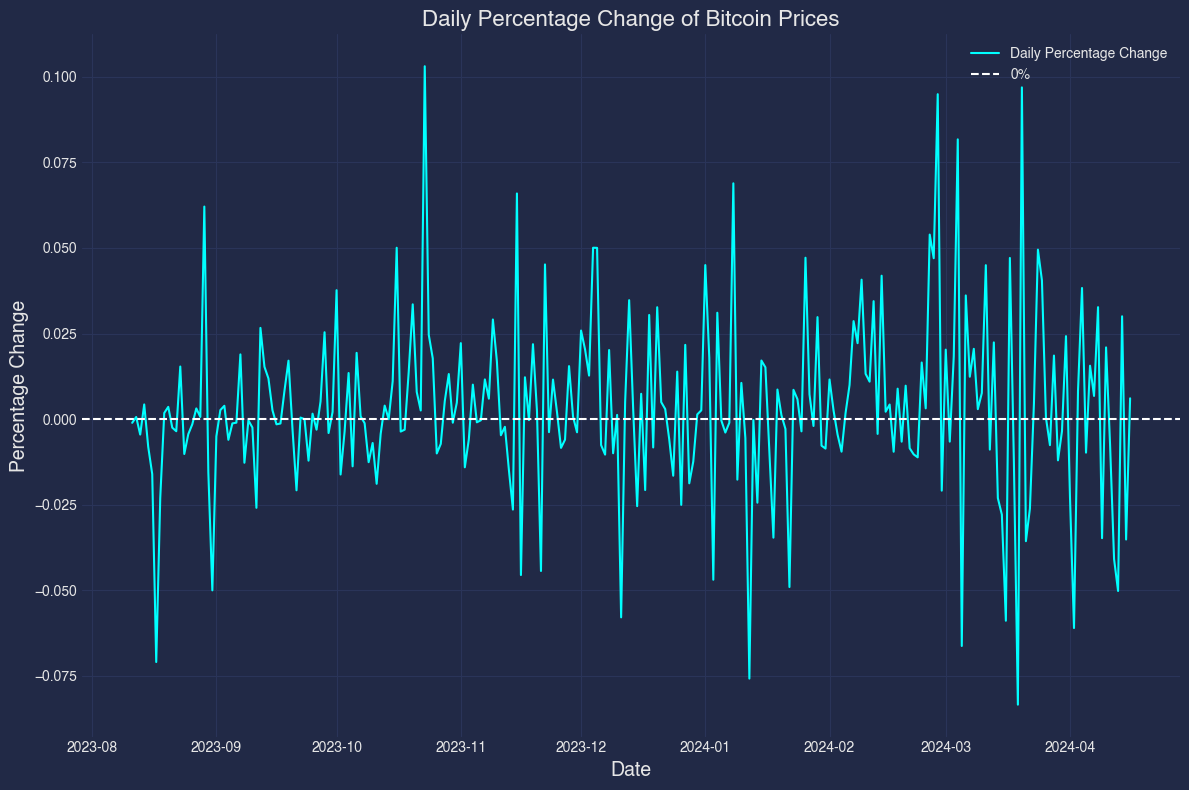

In [18]:
# Create a new figure for plotting with specific dimensions of 12 inches by 8 inches to provide ample space for detailed visualization.
plt.figure(figsize=(12, 8))

# Plot the daily percentage change of Bitcoin prices from the BTCsample DataFrame.
# The data points are represented as a continuous line colored cyan (#00FFFF).
plt.plot(BTCsample.index, BTCsample['Daily_Percentage_Change'], label='Daily Percentage Change', color='#00FFFF')

# Add a horizontal line at y=0, using a white dashed line to indicate the 'no change' level. This helps in visualizing days with no gains or losses.
plt.axhline(y=0, color='white', linestyle='--', label='0%')

# Set the title of the chart with a specific font size of 16 to clearly indicate the subject of the plot.
plt.title('Daily Percentage Change of Bitcoin Prices', fontsize=16)

# Label the x-axis as 'Date' and set its font size to 14 for clarity, explaining what the horizontal axis represents.
plt.xlabel('Date', fontsize=14)

# Label the y-axis as 'Percentage Change' with a font size of 14 to clarify the metric being displayed.
plt.ylabel('Percentage Change', fontsize=14)

# Display the legend to identify each element in the plot, aiding in the visual interpretation of what the lines represent.
plt.legend()

# Adjust the layout to ensure all components of the plot are neatly arranged and visible within the plot area.
plt.tight_layout()

# Display the plot on the screen. This function call is necessary to render the plot when using matplotlib in non-interactive Python environments.
plt.show()

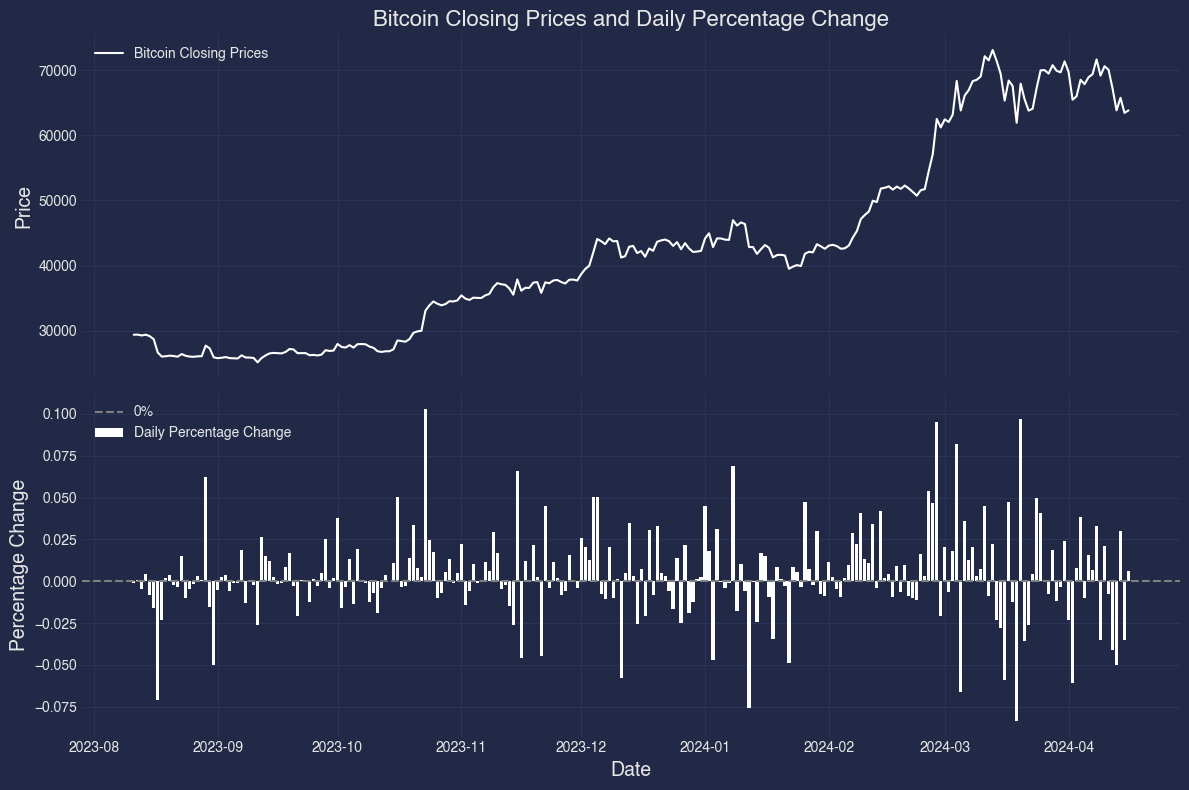

In [19]:
# Initialize a figure with two subplots (ax1 and ax2) arranged vertically, sharing the same x-axis, and set the figure size to 12x8 inches.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot the closing prices of Bitcoin on the first subplot (ax1). Use a white line for visibility.
# Add a label for the legend that identifies the data.
ax1.plot(BTCsample.index, BTCsample['Close'], label='Bitcoin Closing Prices', color='white')
# Set the title for the subplot, which also serves as the title for the entire figure, emphasizing both plots' themes.
ax1.set_title('Bitcoin Closing Prices and Daily Percentage Change', fontsize=16)
# Set the y-axis label of the first subplot to 'Price', with a font size of 14 for clarity.
ax1.set_ylabel('Price', fontsize=14)
# Add a legend to the first subplot to help identify the plotted data.
ax1.legend()

# Plot the daily percentage change of Bitcoin on the second subplot (ax2) using a bar graph with white bars for contrast.
# Add a label for the legend that identifies the data.
ax2.bar(BTCsample.index, BTCsample['Daily_Percentage_Change'], label='Daily Percentage Change', color='white')
# Add a horizontal line at y=0 on the second subplot, using a gray dashed line to indicate the 'no change' level,
# aiding in visualizing neutrality in percentage change.
ax2.axhline(y=0, color='gray', linestyle='--', label='0%')
# Set the x-axis label of the second subplot to 'Date', with a font size of 14, indicating the timeline.
ax2.set_xlabel('Date', fontsize=14)
# Set the y-axis label of the second subplot to 'Percentage Change', with a font size of 14 to clarify what the vertical axis represents.
ax2.set_ylabel('Percentage Change', fontsize=14)
# Add a legend to the second subplot to help identify the plotted elements.
ax2.legend()

# Adjust the layout of the figure to ensure all components fit well and are clearly visible within the plot area.
plt.tight_layout()
# Display the entire figure with both subplots. This call renders the figure in the output.
plt.show()

Searching for effect of volume on Bitcoin Prices.

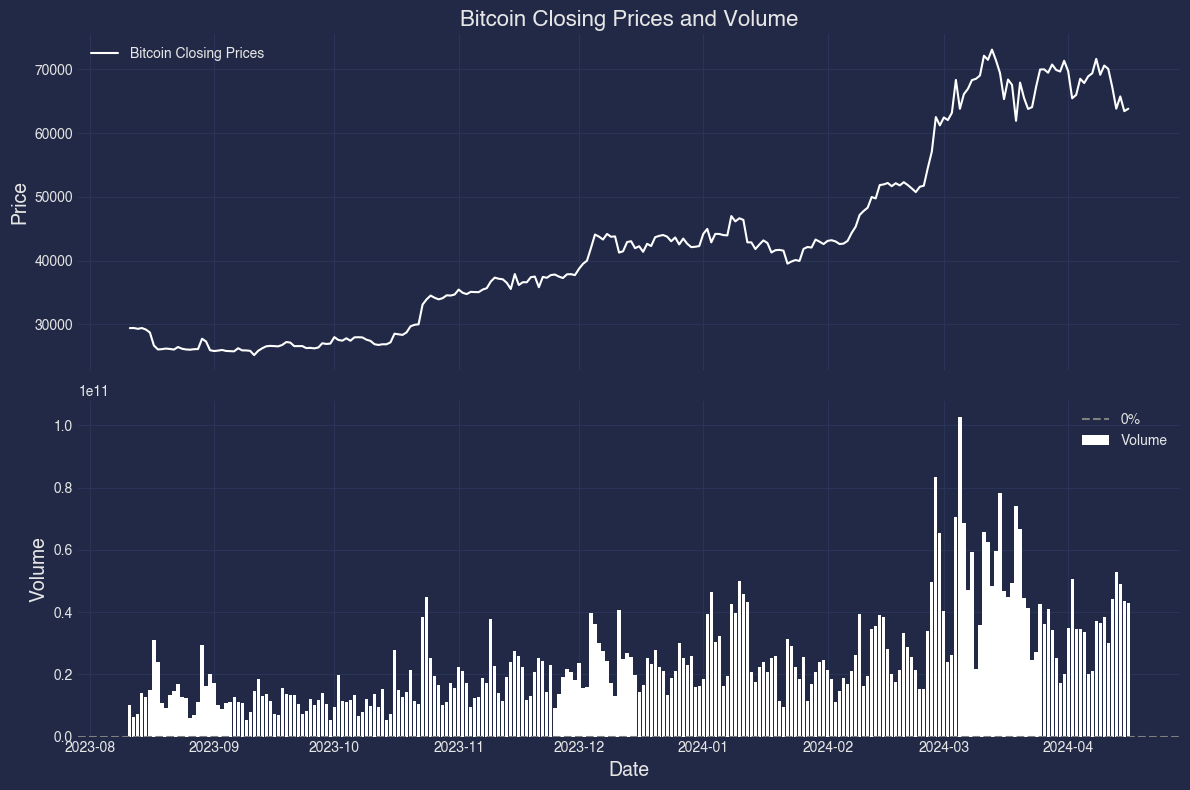

In [20]:
# Initialize a figure with two subplots (ax1 and ax2) arranged vertically, sharing the same x-axis for consistent date alignment, and set the figure size to 12x8 inches for better visibility.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plotting Bitcoin closing prices on the first subplot (ax1).
# Use a white line for high contrast against the background, and add a label for the legend to identify this plot.
ax1.plot(BTCsample.index, BTCsample['Close'], label='Bitcoin Closing Prices', color='white')
# Set a title for the first subplot to indicate the data being shown, with an increased font size for emphasis.
ax1.set_title('Bitcoin Closing Prices and Volume', fontsize=16)
# Label the y-axis to specify that this axis represents the price of Bitcoin.
ax1.set_ylabel('Price', fontsize=14)
# Display a legend in the first subplot to aid in identifying the plotted data.
ax1.legend()

# Plotting the trading volume of Bitcoin on the second subplot (ax2) using a bar chart for clear visual distinction of volume spikes.
# Bars are colored white for consistency with the first plot, and a label 'Volume' is added for the legend.
ax2.bar(BTCsample.index, BTCsample['Volume'], label='Volume', color='white')
# Add a horizontal line at y=0 using a gray dashed line to mark the baseline for the volume, which helps in visual assessment.
ax2.axhline(y=0, color='gray', linestyle='--', label='0%')
# Set the x-axis label to 'Date', with an appropriate font size, ensuring it's readable and indicates the timeline.
ax2.set_xlabel('Date', fontsize=14)
# Label the y-axis to specify that this axis shows the volume of Bitcoin traded.
ax2.set_ylabel('Volume', fontsize=14)
# Include a legend in the second subplot to clearly mark the data representation, facilitating easier interpretation.
ax2.legend()

# Adjust the layout to ensure that all plot components fit well within the figure canvas without any overlap or clutter.
plt.tight_layout()
# Display the plot on the screen. This function call is crucial for rendering the figure in non-interactive Python environments.
plt.show()

Using standard deviation from the mean to calculate the risk of investing in BiTCoin. Im setting anything with a standar deviation of less than 0.02 as a Low Risk Investment.

In [21]:
# Calculate the standard deviation of the daily percentage changes in Bitcoin prices using numpy's std function.
# This measurement helps quantify the volatility of Bitcoin's price movements.
std_deviation = np.std(BTC['Daily_Percentage_Change'])

# Print the calculated standard deviation with a precision of four decimal places.
# This precision is useful for accurately assessing the extent of price fluctuations.
print(f"Standard Deviation of Daily Percentage Changes: {std_deviation:.4f}")

# Use conditional statements to classify the risk level based on the standard deviation.
# A lower standard deviation indicates less volatility and thus lower risk.
if std_deviation <= 0.02:
    print("Low Risk")
elif 0.02 < std_deviation <= 0.05:
    print("Moderate Risk")
else:
    print("High Risk")
# These thresholds (0.02 and 0.05) are arbitrary and can be adjusted based on further risk assessment studies or investment thresholds.

Standard Deviation of Daily Percentage Changes: 0.0346
Moderate Risk


Scaling the data using MinMaxScaler  &  Training and Fitting our model using Relu activation function and dropout layers.

In [22]:
# Import TensorFlow for building deep learning models and MinMaxScaler from sklearn for data normalization.
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Reshape the 'Close' column of the BTC DataFrame to a format suitable for scaling, i.e., a column vector.
closing_prices = BTC['Close'].values.reshape(-1, 1)

# Initialize the MinMaxScaler, which scales each feature to a given range, usually between zero and one.
scaler = MinMaxScaler()

# Fit and transform the closing prices using the scaler. This normalization is a common preprocessing step for neural network inputs.
scaled_prices = scaler.fit_transform(closing_prices)

# Determine the size of the training dataset to be 80% of the total data.
train_size = int(len(scaled_prices) * 0.8)

# Split the scaled data into training and testing datasets based on the calculated train_size.
train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:]

# Define a function to create sequences from the dataset, which are needed for training LSTM models.
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
    return np.array(sequences)

# Set the sequence length, which is the number of time steps the LSTM model will look back.
sequence_length = 10  # This can be adjusted based on the specific temporal structure of the data.

# Generate training and testing data sequences using the defined function and sequence length.
X_train = create_sequences(train_data, sequence_length)
X_test = create_sequences(test_data, sequence_length)

# Construct the LSTM model with two LSTM layers separated by dropout layers to prevent overfitting.
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

# Compile the model using the Adam optimizer and mean squared error loss function, which is common for regression problems.
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the training data, using the earlier part of each sequence as input and the next value as output.
# The model runs for 10 epochs with a batch size of 16, which are parameters that can be tuned during the model optimization process.
model.fit(X_train, train_data[sequence_length:], epochs=10, batch_size=16)

Epoch 1/10
78/78 [==============================] - 1s 3ms/step - loss: 0.0293
Epoch 2/10
78/78 [==============================] - 0s 3ms/step - loss: 0.0042
Epoch 3/10
78/78 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 4/10
78/78 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 5/10
78/78 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 6/10
78/78 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 7/10
78/78 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 8/10
78/78 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 9/10
78/78 [==============================] - 0s 3ms/step - loss: 0.0035
Epoch 10/10
78/78 [==============================] - 0s 3ms/step - loss: 0.0026


Splitting into training and testing data with 80% of the data being used for training. since we dont have a y variable the usual train_test_split method wont work here.

In [23]:
predicted_scaled_prices = model.predict(X_test)

10/10 [==============================] - 0s 1ms/step


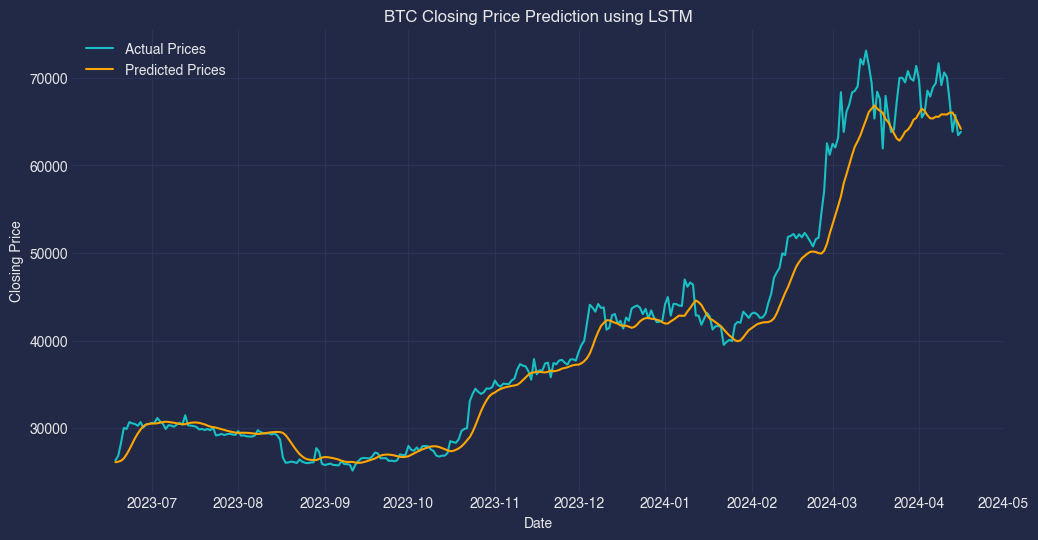

In [24]:
# Convert the predicted scaled prices back to their original scale using the inverse transformation of the scaler.
# This step is essential to compare the predicted prices to the actual prices in their original units.
predicted_prices = scaler.inverse_transform(predicted_scaled_prices)

# Initialize a plot with a specific size (12 inches wide by 6 inches tall) to ensure all details are visible.
plt.figure(figsize=(12, 6))

# Plot the actual closing prices on the graph. The data starts from 'train_size + sequence_length' to avoid the initial training set and sequence length.
# This plot shows the real Bitcoin closing prices as a baseline for comparison.
plt.plot(BTC.index[train_size+sequence_length:], closing_prices[train_size+sequence_length:], label='Actual Prices')

# Plot the predicted prices using an orange line for visibility and distinction from the actual prices.
# The predicted prices are plotted over the same indices as the actual prices for direct comparison.
plt.plot(BTC.index[train_size+sequence_length:], predicted_prices, label='Predicted Prices', color='orange')

# Set the title of the chart to 'BTC Closing Price Prediction using LSTM' to describe the content and method used for prediction.
plt.title('BTC Closing Price Prediction using LSTM')

# Label the x-axis as 'Date' to indicate the time frame of the data being plotted.
plt.xlabel('Date')

# Label the y-axis as 'Closing Price' to indicate the monetary value of the Bitcoin prices.
plt.ylabel('Closing Price')

# Add a legend to the plot to help distinguish between the actual and predicted prices.
plt.legend()

# Display the plot. This command renders the visualization on the screen, crucial for seeing the comparison between actual and predicted prices.
plt.show()

Plotting our model predictions over the entire data to see how well it fits.

Now to create future predictions we will be taking the entire dataset as training and we will be trying to extract predictions of the next 50 days.

In [25]:
# Assign the scaled prices to full_train_data for clarity, indicating that the entire dataset will be used for model training.
# Using the full dataset can maximize the learning potential and improve model performance.
full_train_data = scaled_prices

# Generate sequences from the full dataset using the previously defined create_sequences function.
# The function takes the full dataset and the sequence_length as inputs to produce a series of sequential data points.
# These sequences are necessary for training the LSTM model, which requires input data in the form of sequences to capture temporal dependencies.
X_full_train = create_sequences(full_train_data, sequence_length)

In [26]:
future_predictions_scaled = model.predict(X_full_train[-50:])

2/2 [==============================] - 0s 5ms/step


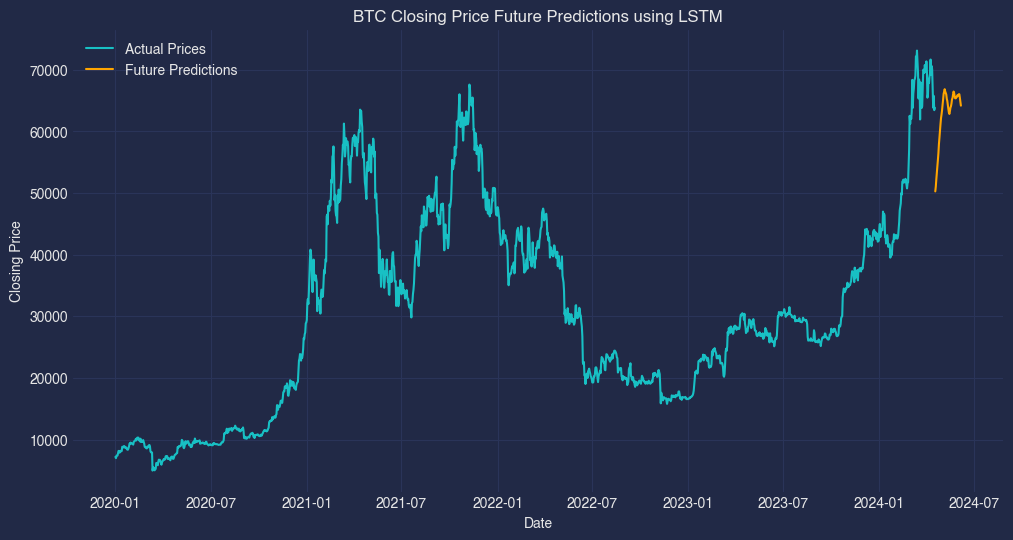

In [27]:
# Convert the scaled predictions back to their original scale using the inverse transformation of the scaler.
# This is crucial for making the predicted values comparable to the actual historical prices.
future_predictions = scaler.inverse_transform(future_predictions_scaled)

# Initialize a plot with a specified size (12 inches wide by 6 inches tall) to ensure all details are clearly visible.
plt.figure(figsize=(12, 6))

# Plot the actual closing prices of Bitcoin across the entire dataset.
# This line serves as a reference for comparing the historical data with the future predictions.
plt.plot(BTC.index, closing_prices, label='Actual Prices')

# Plot the future predictions starting from the day after the last available data point.
# Generate a date range for 50 days beyond the last date in the BTC index to align with the number of future predictions.
# The color orange is used for these predictions to distinguish them from the actual historical data.
plt.plot(pd.date_range(start=BTC.index[-1], periods=51, freq='D')[1:], future_predictions, label='Future Predictions', color='orange')

# Set the title of the chart to indicate that it displays future predictions for BTC closing prices using an LSTM model.
plt.title('BTC Closing Price Future Predictions using LSTM')

# Label the x-axis as 'Date' to indicate the timeline of the data being plotted.
plt.xlabel('Date')

# Label the y-axis as 'Closing Price' to indicate the monetary value of the Bitcoin prices being plotted.
plt.ylabel('Closing Price')

# Add a legend to the plot to help distinguish between actual historical prices and future predictions.
plt.legend()

# Display the plot. This command renders the visualization on the screen, crucial for visual analysis of predicted versus actual prices.
plt.show()

In [28]:
import pandas as pd

# Create a date range for the predicted prices, starting the day after the last date in the BTC data.
prediction_dates = pd.date_range(start=BTC.index[-1] + pd.Timedelta(days=1), periods=len(future_predictions), freq='D')

# Create a DataFrame for the future predictions.
future_df = pd.DataFrame(data=future_predictions, index=prediction_dates, columns=['Predicted Closing Price'])

# Convert the historical closing prices into a DataFrame for consistency.
historical_df = pd.DataFrame(data=closing_prices, index=BTC.index, columns=['Actual Closing Price'])

# Concatenate the historical and future DataFrames for a continuous view.
full_df = pd.concat([historical_df, future_df])

# Print the DataFrame to display the results.
print(full_df.tail(60))  # Display the last 60 entries to see some of the historical data and all the predictions.

            Actual Closing Price  Predicted Closing Price
2024-04-07          69362.554688                      NaN
2024-04-08          71631.359375                      NaN
2024-04-09          69139.015625                      NaN
2024-04-10          70587.882812                      NaN
2024-04-11          70060.609375                      NaN
2024-04-12          67195.867188                      NaN
2024-04-13          63821.472656                      NaN
2024-04-14          65738.726562                      NaN
2024-04-15          63426.210938                      NaN
2024-04-16          63811.863281                      NaN
2024-04-17                   NaN             50246.515625
2024-04-18                   NaN             51030.875000
2024-04-19                   NaN             52214.312500
2024-04-20                   NaN             53256.515625
2024-04-21                   NaN             54311.003906
2024-04-22                   NaN             55338.964844
2024-04-23    

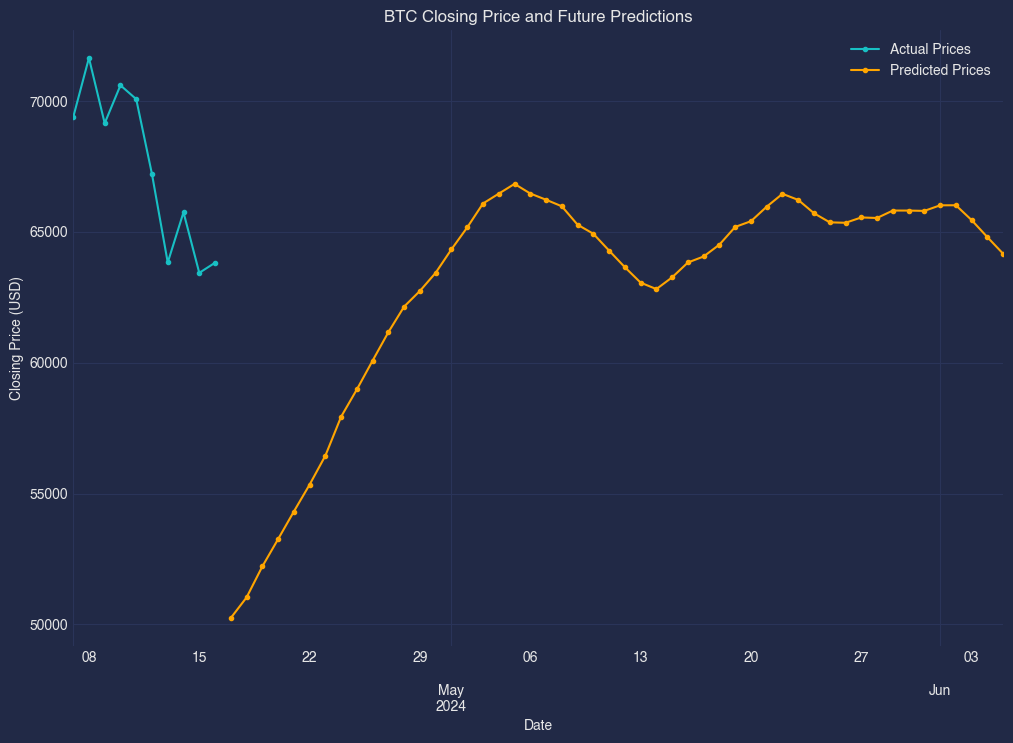

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data creation: Dates and prices
dates = pd.date_range(start='2024-04-07', periods=60, freq='D')
actual_prices = [69362.554688, 71631.359375, 69139.015625, 70587.882812, 70060.609375, 67195.867188, 63821.472656, 65738.726562, 63426.210938, 63811.863281] + [None]*50
predicted_prices = [None]*10 + [50246.515625, 51030.875000, 52214.312500, 53256.515625, 54311.003906, 55338.964844, 56443.910156, 57933.734375, 58976.523438, 60077.500000, 61163.550781, 62140.476562, 62736.113281, 63430.492188, 64325.542969, 65160.996094, 66073.945312, 66450.085938, 66823.109375, 66455.273438, 66217.609375, 65967.992188, 65264.800781, 64919.203125, 64275.023438, 63641.562500, 63052.191406, 62806.437500, 63255.285156, 63821.480469, 64051.578125, 64505.367188, 65179.476562, 65398.765625, 65953.117188, 66444.164062, 66210.226562, 65701.906250, 65354.792969, 65338.234375, 65541.750000, 65521.300781, 65805.203125, 65804.507812, 65792.250000, 66005.125000, 66007.437500, 65441.003906, 64788.863281, 64154.824219]

# Create a DataFrame
data = {
    "Date": dates,
    "Actual Closing Price": actual_prices,
    "Predicted Closing Price": predicted_prices
}
df = pd.DataFrame(data).set_index('Date')

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
df['Actual Closing Price'].plot(ax=ax, style='.-', label='Actual Prices')
df['Predicted Closing Price'].plot(ax=ax, style='.-', color='orange', label='Predicted Prices')
plt.title('BTC Closing Price and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()